In [1]:
import numpy as np
import pycbc.waveform as pycbc_wf
import bilby
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt
import pycbc
from gwosc import datasets
from gwpy.timeseries import TimeSeries

In [22]:
def time_domain_model(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Time Domain Model for the inspiral phase """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 20.0)
#    maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    
#     waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
#         phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    
    minimum_time = time_array[0]
    maximum_time = time_array[-1]
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)

    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    delta_time = time_array[1] - time_array[0]
    time_bounds = ((time_array >= minimum_time) *
                        (time_array <= maximum_time))
    

    hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',#'SpinTaylorT4',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase,  delta_t = delta_time,
            f_lower = start_frequency, f_ref=reference_frequency)
            #**waveform_dictionary)

    h_plus = np.zeros_like(time_array, dtype=complex)
    h_cross = np.zeros_like(time_array, dtype=complex)


    if len(hplus.data.data) > len(time_array):

        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]

        
    else:
        h_plus[-len(hplus.data.data):] = hplus.data.data
        h_cross[-len(hcross.data.data):] = hcross.data.data

    h_plus *= time_bounds
    h_cross *= time_bounds
    
#     tindex = np.argmax(h_plus)
#     zeros_length = len(h_plus[tindex:])
    
#     h_plus = h_plus[:tindex]
#     h_cross = h_cross[:tindex]
    
#     h_plus = np.concatenate((np.zeros(zeros_length), h_plus))
#     h_cross = np.concatenate((np.zeros(zeros_length), h_cross))
    



    return dict( plus=h_plus, cross=h_cross)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (15504990.py, line 68)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


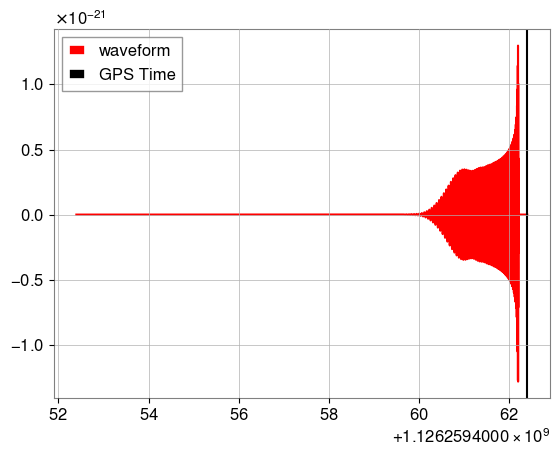

In [23]:
tg = 1126259462.4
t = np.arange(tg-10,tg,1/2048)
model = time_domain_model(t, 20, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

model1 = time_domain_model(t, 70, 30, 10000, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']



plt.plot(t, model,color='r',label='waveform')
#plt.plot(t,model1,color='b',label='waveform1')
#plt.xlim([tg-5,tg+0.1])

plt.axvline(tg,color='k',label='GPS Time')
plt.legend()
plt.show()

In [25]:
time_domain_model(t, 20, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)

{'plus': array([ 0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j, ..., -5.95510975e-27+0.j,
        -1.08248538e-26+0.j, -1.60419456e-26+0.j]),
 'cross': array([0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, ..., 7.95306258e-26+0.j,
        7.90867254e-26+0.j, 7.90738541e-26+0.j])}

In [5]:
logger = bilby.core.utils.logger
outdir = "outdir_realdata_1"
label = "GW150914"

In [28]:
# Note you can get trigger times using the gwosc package, e.g.:
# > from gwosc import datasets
# > datasets.event_gps("GW150914")

event = "GW150914"
trigger_time = datasets.event_gps(event)

detectors = ["H1", "L1"]
maximum_frequency = 1024
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 4  # Analysis segment duration
post_trigger_duration = 0  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

sampling_frequency = 4096

In [29]:
psd_duration = 32 * duration
psd_start_time = start_time - psd_duration
psd_end_time = start_time

In [30]:
ifo_list = bilby.gw.detector.InterferometerList([])

In [31]:
ifo_list

[]

In [32]:
for det in detectors:
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    data = TimeSeries.fetch_open_data(det, start_time, end_time)
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

logger.info("Saving data plots to {}".format(outdir))
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

22:11 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:11 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2
22:11 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:11 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


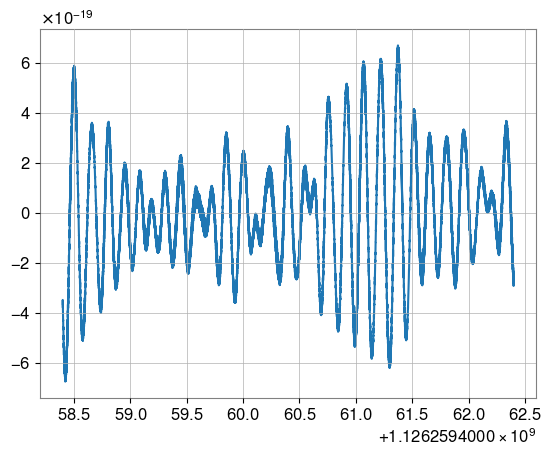

In [33]:
plt.plot(ifo_list[0].time_array, ifo_list[0].time_domain_strain)

In [41]:
priors = bilby.gw.prior.BBHPriorDict(filename="GW150914.prior")

In [49]:
priors

{'chirp_mass': UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None),
 'mass_ratio': UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'mass_1': Constraint(minimum=10, maximum=80, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=10, maximum=80, name='mass_2', latex_label='$m_2$', unit=None),
 'a_1': Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None),
 'a_2': Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None),
 'tilt_1': Sine(minimum=0, maximum=3.141592653589793, name='tilt_1', latex_label='$\\theta_1$', unit=None, boundary=None),
 'tilt_2': Sine(minimum=0, maximum=3.141592653589793, name='tilt_2', latex_label='$\\theta_2$', unit=None, boundary=None),
 'phi_12': Uniform(minimum=0, maximum=6.283185307179586, name='phi_12', lat

In [34]:
priors.pop('geocent_time')

Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None)

In [51]:
priors["geocent_time"] = bilby.prior.Uniform(minimum=start_time+2, maximum=end_time, name='geocent_time', latex_label='$g_t$', unit='sec', boundary=None)

In [53]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_model,
    start_time=start_time,
    
)

22:27 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_model
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [54]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifo_list, waveform_generator, priors=priors)

In [ ]:
result = bilby.run_sampler(
    likelihood,
    priors,
    sampler="dynesty",
    outdir=outdir,
    label=label,
    nlive=1000,
    check_point_delta_t=600,
    check_point_plot=True,
    npool=1,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
)

22:27 bilby INFO    : Running for label 'GW150914', output will be saved to 'outdir_realdata_1'
22:27 bilby INFO    : Using lal version 7.1.7
22:27 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
22:27 bilby INFO    : Using lalsimulation version 3.1.2
22:27 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
22:27 bilby INFO    : Search parameters:
22:27 bilby INFO    :   chirp_mass = UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None)
22:27 bilby INFO    :   mass_ratio = UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', un

0it [00:00, ?it/s]

22:27 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f13cce7a4f0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
22:27 bilby INFO    : Checkpoint every check_point_delta_t = 600s
22:27 bilby INFO    : Using dynesty version 1.0.1
22:27 bilby INFO    : Using the bi

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
22:48 bilby INFO    : Written checkpoint file outdir_realdata_1/GW150914_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values 

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
23:19 bilby INFO    : Written checkpoint file outdir_realdata_1/GW150914_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values 

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

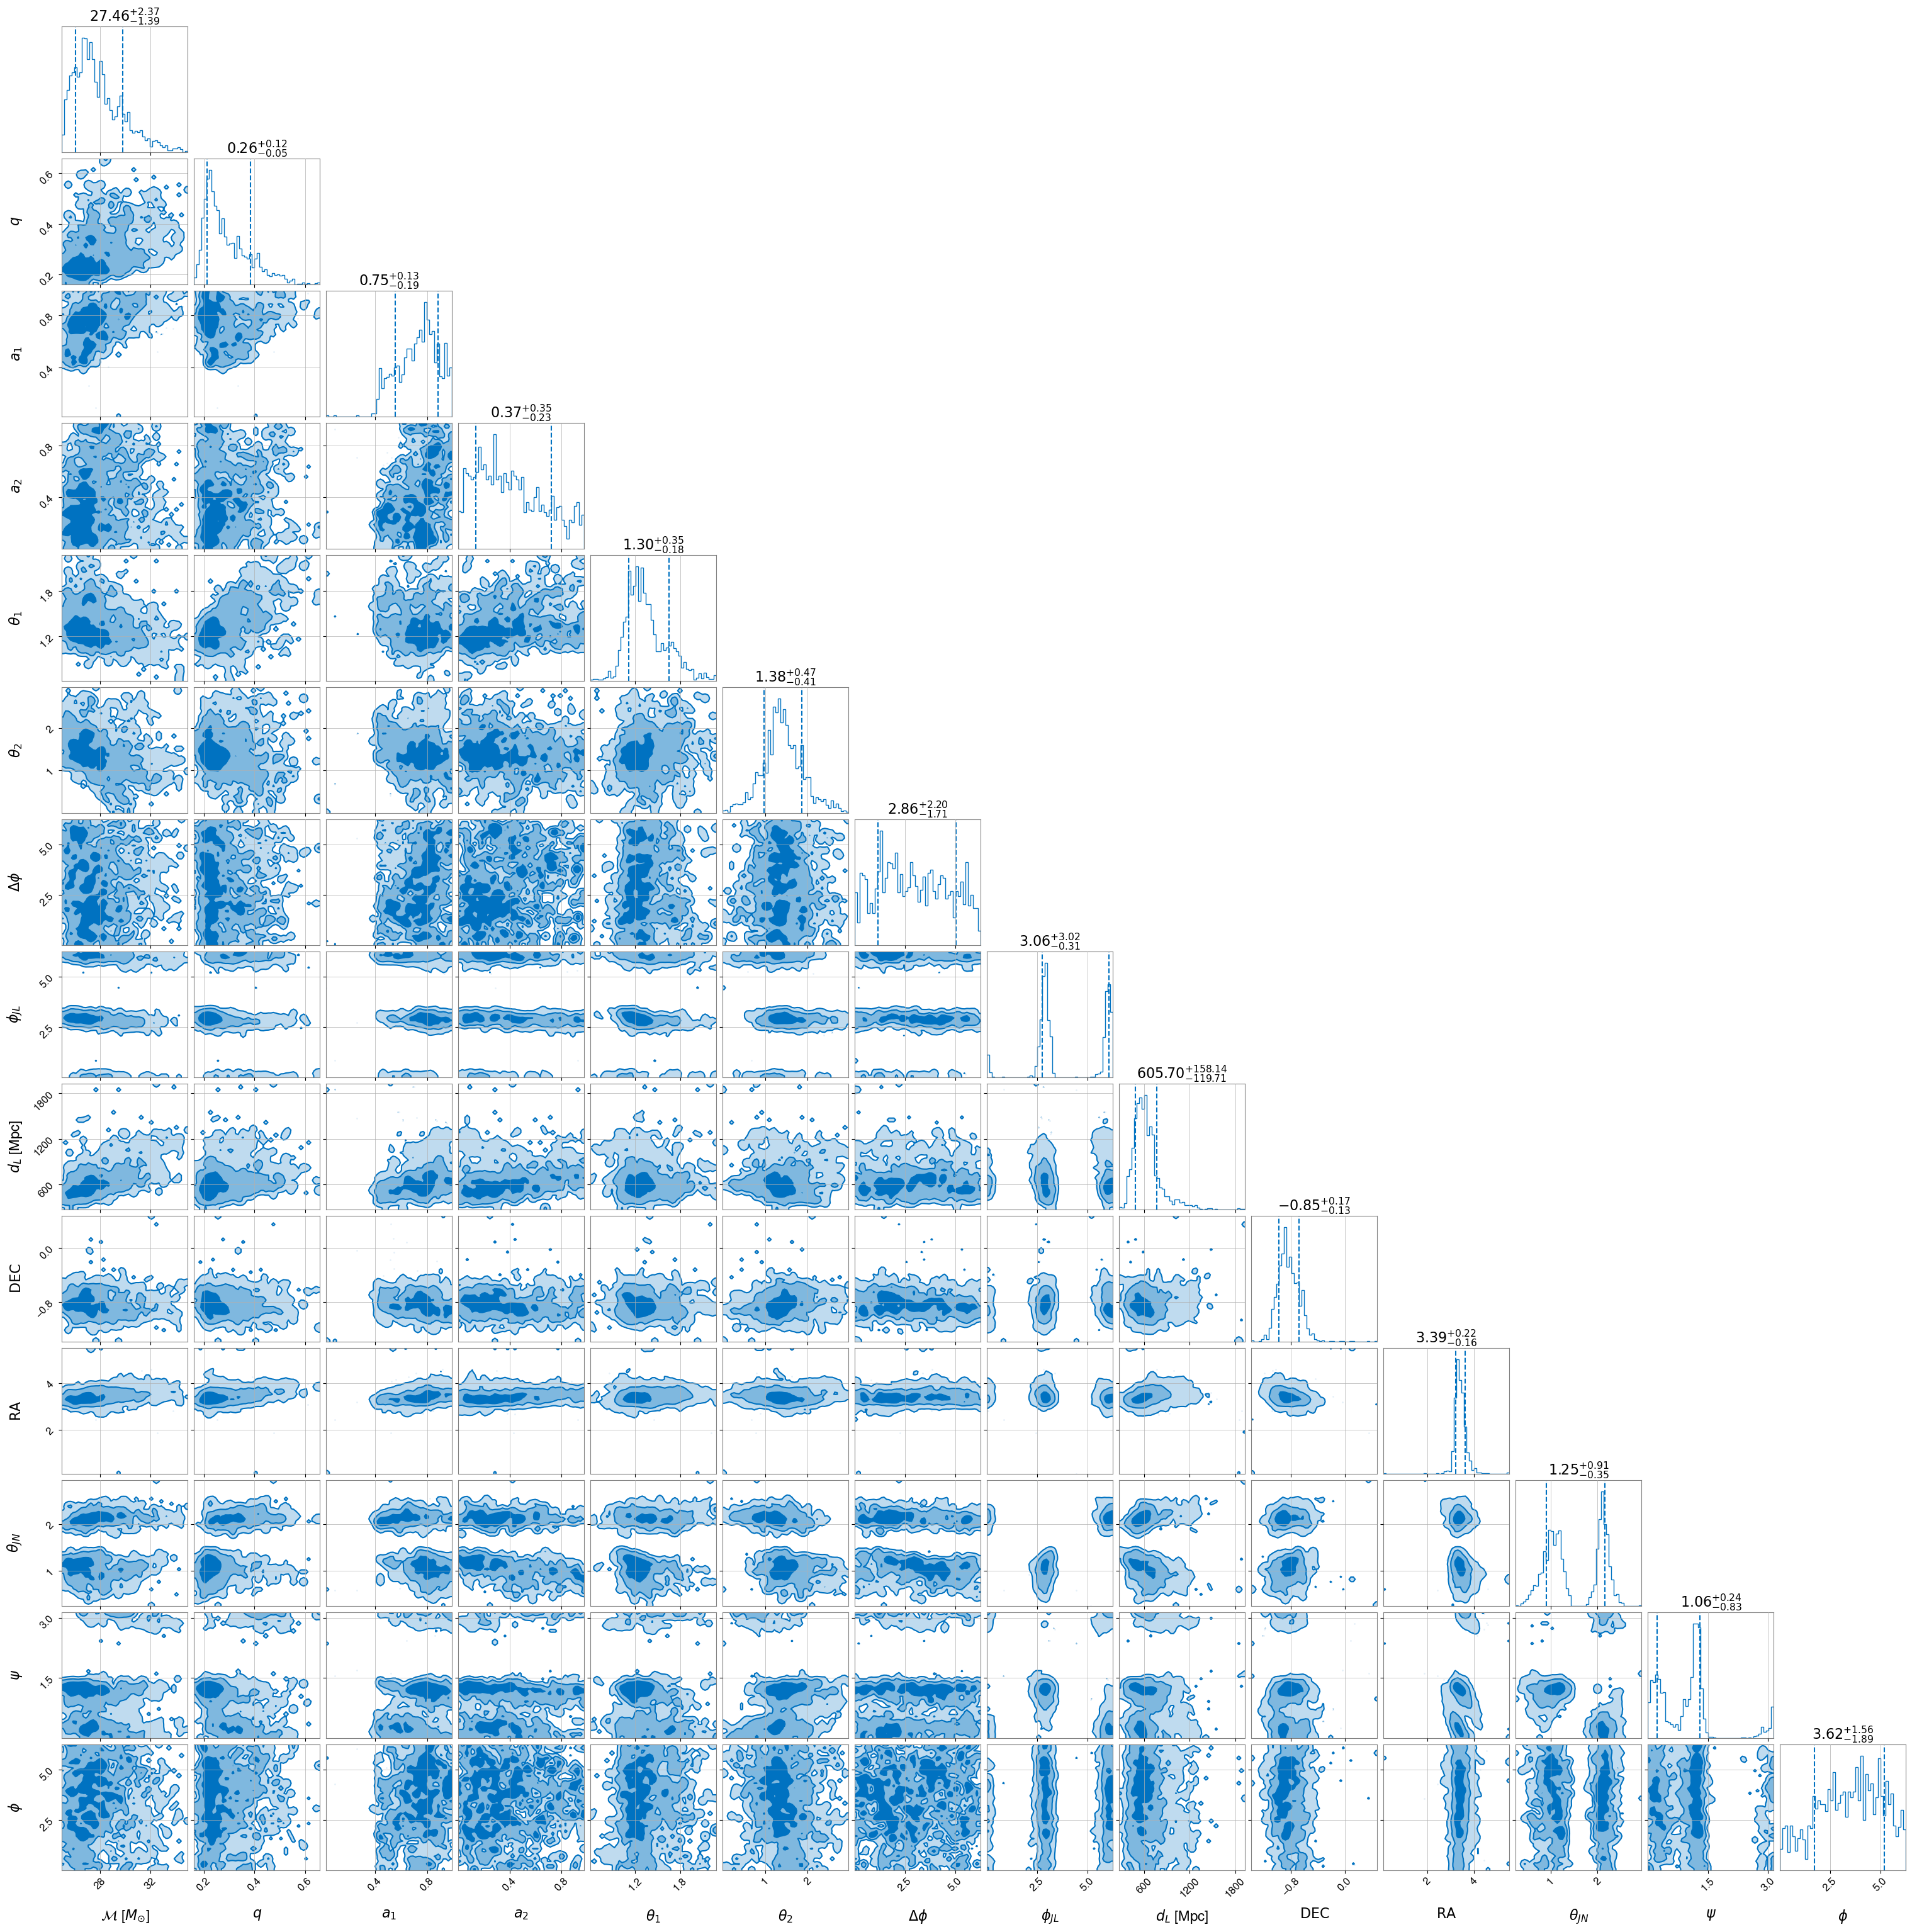

In [19]:
result.plot_corner()

In [20]:
res = bilby.core.result.Result(result)

In [22]:
res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,luminosity_distance,dec,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,29.863020,0.478985,0.413836,0.633808,3.011207,0.442687,1.995357,4.052997,1411.767359,-0.986711,...,0.271504,0.117584,-0.991512,0.903604,0.268774,1112.701612,39.586659,18.961420,23.536902,58.548080
1,25.610418,0.531183,0.075853,0.501781,0.875822,1.595721,3.101160,0.496918,1885.107579,-1.105552,...,0.501625,0.244122,0.640366,-0.024922,0.345374,1401.177060,30.299297,16.094465,19.035906,46.393762
2,32.953232,0.643826,0.472871,0.025161,2.356971,0.915185,3.589179,4.174333,1691.484434,0.805334,...,0.019945,0.334111,-0.707656,0.609644,0.314576,1286.714382,36.059723,23.216171,25.067566,59.275894
3,33.626797,0.825361,0.791012,0.321268,0.689819,2.238923,5.471799,5.014799,1538.745558,0.085024,...,0.252190,0.503399,0.771361,-0.619517,0.289771,1193.037547,32.995615,27.233289,26.071907,60.228904
4,31.449785,0.396953,0.328855,0.536528,1.981398,2.157328,5.605289,2.766651,1452.202981,0.677657,...,0.446856,0.301521,-0.399161,-0.553476,0.275500,1138.536651,45.891266,18.216694,24.656838,64.107961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15518,33.449977,0.312856,0.896439,0.664910,0.443812,0.309221,3.062754,3.077747,1715.619153,-0.605147,...,0.202343,0.384917,0.903122,0.952571,0.318453,1301.236003,53.798197,16.831089,25.370615,70.629286
15519,33.449977,0.312856,0.896439,0.664910,0.443812,0.309221,3.062754,3.077747,1715.619153,-0.605147,...,0.202343,0.384917,0.903122,0.952571,0.318453,1301.236003,53.798197,16.831089,25.370615,70.629286
15520,32.242205,0.346207,0.852317,0.673710,0.505602,0.520138,1.472637,3.634276,1773.352786,-0.549338,...,0.334834,0.412806,0.874883,0.867750,0.327683,1335.674917,48.702496,16.861145,24.284567,65.563641
15521,31.551838,0.800853,0.969797,0.832172,0.786327,1.036417,5.585015,3.453646,1367.265431,-0.445129,...,0.716155,0.686386,0.706450,0.509307,0.261330,1083.987361,32.148442,25.746186,25.014743,57.894628


In [49]:
pwd

'/home1/akash.mishra/Area_law/Notebooks'

In [23]:
mass_1 = res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior['mass_1_source']
mass_2 = res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior['mass_2_source']

(array([1490., 3178., 2693., 2276., 2150., 1611., 1274.,  707.,
         136.,    8.]),
 array([22.85081386, 27.80203555, 32.75325724, 37.70447892,
        42.65570061, 47.6069223 , 52.55814399, 57.50936568,
        62.46058736, 67.41180905, 72.36303074]),
 <BarContainer object of 10 artists>)

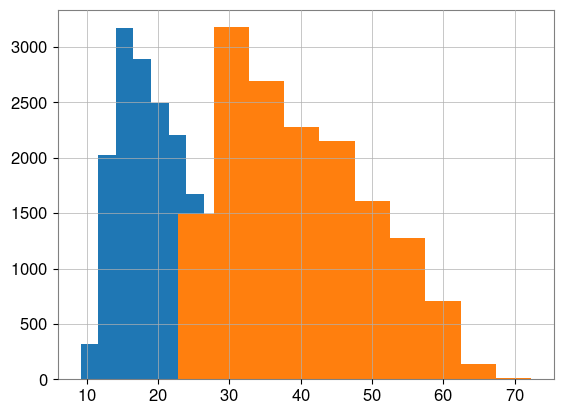

In [24]:
plt.hist(mass_2)
plt.hist(mass_1)

In [60]:
len(mass_2)

878

In [83]:
len(res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir/GW150914_result.json').posterior['chirp_mass'])

4290

In [84]:
4290/878

4.886104783599089